<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/W3D2/tutorials/W3D2_DynamicNetworks/W3D2_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 3, Day 2, Tutorial 1
# Neuronal Network Dynamics: Neural Rate Models

__Content creators:__ Qinglong Gu, Songtin Li, Arvind Kumar, John Murray, Julijana Gjorgjieva 

__Content reviewers:__  Maryam Vaziri-Pashkam, Ella Batty, Lorenzo Fontolan, Richard Gao, Spiros Chavlis, Michael Waskom


---
# Tutorial Objectives

The brain is a complex system, not because it is composed of a large number of diverse types of neurons, but mainly because of how neurons are connected to each other. The brain is indeed a network of highly specialized neuronal networks. 

The activity of a neural network constantly evolves in time. For this reason, neurons can be modeled as dynamical systems. The dynamical system approach is only one of the many modeling approaches that computational neuroscientists have developed (other points of view include information processing,  statistical models, etc.). 

How the dynamics of neuronal networks affect the representation and processing of information in the brain is an open question. However, signatures of altered brain dynamics present in many brain diseases (e.g., in epilepsy or Parkinson's disease) tell us that it is crucial to study network activity dynamics if we want to understand the brain.

In this tutorial, we will simulate and study one of the simplest models of biological neuronal networks. Instead of modeling and simulating individual excitatory neurons (e.g., LIF models that you implemented yesterday), we will treat them as a single homogeneous population and approximate their dynamics using a single one-dimensional equation describing the evolution of their average spiking rate in time.

In this tutorial, we will learn how to build a firing rate model of a single population of excitatory neurons. 

**Steps:**
- Write the equation for the firing rate dynamics of a 1D excitatory population.
- Visualize the response of the population as a function of parameters such as threshold level and gain, using the frequency-current (F-I) curve.
- Numerically simulate the dynamics of the excitatory population and find the fixed points of the system. 
- Investigate the stability of the fixed points by linearizing the dynamics around them.
 


---
# Setup

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt       # root-finding algorithm

In [2]:
# @title Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [3]:
# @title Helper functions


def plot_fI(x, f):
  plt.figure(figsize=(6, 4))  # plot the figure
  plt.plot(x, f, 'k')
  plt.xlabel('x (a.u.)', fontsize=14)
  plt.ylabel('F(x)', fontsize=14)
  plt.show()


def plot_dr_r(r, drdt):
  plt.figure()
  plt.plot(r, drdt, 'k')
  plt.plot(r, 0. * r, 'k--')
  plt.xlabel(r'$r$')
  plt.ylabel(r'$\frac{dr}{dt}$', fontsize=20)
  plt.ylim(-0.1, 0.1)


def plot_dFdt(x, dFdt):
  plt.figure()
  plt.plot(x, dFdt, 'r')
  plt.xlabel('x (a.u.)', fontsize=14)
  plt.ylabel('dF(x)', fontsize=14)
  plt.show()

---
# Section 1: Neuronal network dynamics

Video available at https://youtube.com/watch?v=p848349hPyw


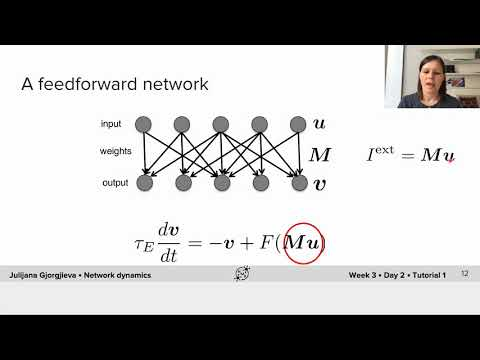

In [4]:
# @title Video 1: Dynamic networks
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="p848349hPyw", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

## Section 1.1: Dynamics of a single excitatory population

Individual neurons respond by spiking. When we average the spikes of neurons in a population, we can define the average firing activity of the population. In this model, we are interested in how the population-averaged firing varies as a function of time and network parameters. Mathematically, we can describe the firing rate dynamic as:

\begin{align}
\tau \frac{dr}{dt} &= -r + F(w\cdot r + I_{\text{ext}})  \quad\qquad (1)
\end{align}

$r(t)$ represents the average firing rate of the excitatory population at time $t$, $\tau$ controls the timescale of the evolution of the average firing rate, $w$ denotes the strength (synaptic weight) of the recurrent input to the population, $I_{\text{ext}}$ represents the external input, and the transfer function $F(\cdot)$ (which can be related to f-I curve of individual neurons described in the next sections) represents the population activation function in response to all received inputs.

To start building the model, please execute the cell below to initialize the simulation parameters.

In [5]:
# @markdown Execute this cell to set default parameters for a single excitatory population model


def default_pars_single(**kwargs):
  pars = {}

  # Excitatory parameters
  pars['tau'] = 1.     # Timescale of the E population [ms]
  pars['a'] = 1.2      # Gain of the E population
  pars['theta'] = 2.8  # Threshold of the E population

  # Connection strength
  pars['w'] = 0.  # E to E, we first set it to 0

  # External input
  pars['I_ext'] = 0.

  # simulation parameters
  pars['T'] = 20.       # Total duration of simulation [ms]
  pars['dt'] = .1       # Simulation time step [ms]
  pars['r_init'] = 0.2  # Initial value of E

  # External parameters if any
  for k in kwargs:
    pars[k] = kwargs[k]

  # Vector of discretized time points [ms]
  pars['range_t'] = np.arange(0, pars['T'], pars['dt'])

  return pars


You can use:
- `pars = default_pars_single()` to get all the parameters, and then you can execute `print(pars)` to check these parameters. 
- `pars = default_pars_single(T=T_sim, dt=time_step)` to set new simulation time and time step
- After `pars = default_pars_single()`, use `pars['New_para'] = value` to add an new parameter with its value

## Section 1.2: F-I curves
In electrophysiology, a neuron is often characterized by its spike rate output in response to input currents. This is often called the **F-I** curve, denoting the output spike frequency (**F**) in response to different injected currents (**I**). We estimated this for an LIF neuron in yesterday's tutorial.

The transfer function $F(\cdot)$ in Equation $1$ represents the gain of the population as a function of the total input. The gain is often modeled as a sigmoidal function, i.e., more input drive leads to a nonlinear increase in the population firing rate. The output firing rate will eventually saturate for high input values. 

A sigmoidal $F(\cdot)$ is parameterized by its gain $a$ and threshold $\theta$.

$$ F(x;a,\theta) = \frac{1}{1+\text{e}^{-a(x-\theta)}} - \frac{1}{1+\text{e}^{a\theta}}  \quad(2)$$

The argument $x$ represents the input to the population. Note that the second term is chosen so that $F(0;a,\theta)=0$.

Many other transfer functions (generally monotonic) can be also used. Examples are the rectified linear function $ReLU(x)$ or the hyperbolic tangent $tanh(x)$.

### Exercise 1: Implement F-I curve 

Let's first investigate the activation functions before simulating the dynamics of the entire population. 

In this exercise, you will implement a sigmoidal **F-I** curve or transfer function $F(x)$, with gain $a$ and threshold level $\theta$ as parameters.

In [6]:
def F(x, a, theta):
  """
  Population activation function.

  Args:
    x (float): the population input
    a (float): the gain of the function
    theta (float): the threshold of the function

  Returns:
    float: the population activation response F(x) for input x
  """
  #################################################
  ## TODO for students: compute f = F(x) ##
  # Fill out function and remove
  raise NotImplementedError("Student excercise: implement the f-I function")
  #################################################
  # add the expression of f = F(x)
  f = ...

  return f


pars = default_pars_single()  # get default parameters
x = np.arange(0, 10, .1)      # set the range of input

# Uncomment below to test your function
# f = F(x, pars['a'], pars['theta'])

# plot_fI(x, f)

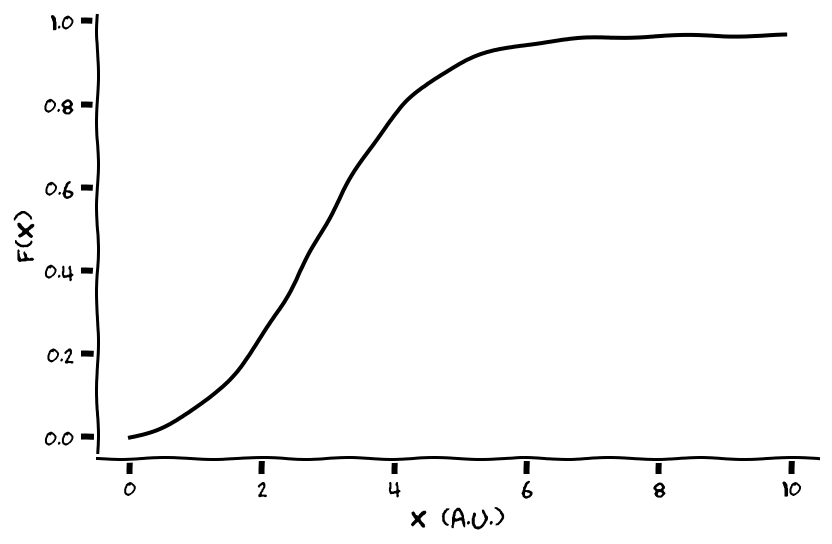

In [7]:
# to_remove solution


def F(x, a, theta):
  """
  Population activation function.

  Args:
    x (float): the population input
    a (float): the gain of the function
    theta (float): the threshold of the function

  Returns:
    float: the population activation response F(x) for input x
  """

  # add the expression of f = F(x)
  f = (1 + np.exp(-a * (x - theta)))**-1 - (1 + np.exp(a * theta))**-1

  return f


pars = default_pars_single()  # get default parameters
x = np.arange(0, 10, .1)      # set the range of input

# Uncomment below to test your function
f = F(x, pars['a'], pars['theta'])

with plt.xkcd():
  plot_fI(x, f)

### Interactive Demo: Parameter exploration of F-I curve
Here's an interactive demo that shows how the F-I curve changes for different values of the gain and threshold parameters. How do the gain and threshold parameters affect the F-I curve?

In [8]:
# @title

# @markdown Make sure you execute this cell to enable the widget!


def interactive_plot_FI(a, theta):
  """
  Population activation function.

  Expecxts:
    a     : the gain of the function
    theta : the threshold of the function

  Returns:
    plot the F-I curve with give parameters
  """

  # set the range of input
  x = np.arange(0, 10, .1)
  plt.figure()
  plt.plot(x, F(x, a, theta), 'k')
  plt.xlabel('x (a.u.)', fontsize=14)
  plt.ylabel('F(x)', fontsize=14)
  plt.show()


_ = widgets.interact(interactive_plot_FI, a=(0.3, 3, 0.3), theta=(2, 4, 0.2))

interactive(children=(FloatSlider(value=1.5, description='a', max=3.0, min=0.3, step=0.3), FloatSlider(value=3…

In [9]:
# to_remove explanation

"""
Discussion: 

For the function we have chosen to model the F-I curve (eq 2), 
- a determines the slope (gain) of the rising phase of the F-I curve 
- theta determines the input at which the function F(x) reaches its mid-value (0.5). 
That is, theta shifts the F-I curve along the horizontal axis.

For our neurons we are using in this tutorial: 
- a controls the gain of the neuron population 
- theta controls the threshold at which the neuron population starts to respond
""";

## Section 1.3: Simulation scheme of E dynamics

Because $F(\cdot)$ is a nonlinear function, the exact solution of Equation $1$ can not be determined via analytical methods. Therefore, numerical methods must be used to find the solution. In practice, the derivative on the left-hand side of Equation $1$ can be approximated using the Euler method on a time-grid of stepsize $\Delta t$:

\begin{align}
&\frac{dr}{dt} \approx \frac{r[k+1]-r[k]}{\Delta t} 
\end{align}
where $r[k] = r(k\Delta t)$. 

Thus,

$$\Delta r[k] = \frac{\Delta t}{\tau}[-r[k] + F(w\cdot r[k] + I_{\text{ext}}(k;a,\theta))]$$


Hence, Equation (1) is updated at each time step by:

$$r[k+1] = r[k] + \Delta r[k]$$


In [10]:
# @markdown Execute this cell to enable the single population rate model simulator: `simulate_single`


def simulate_single(pars):
  """
  Simulate an excitatory population of neurons

  Args:
    pars   : Parameter dictionary

  Returns:
    rE     : Activity of excitatory population (array)

  Example:
    pars = default_pars_single()
    r = simulate_single(pars)
  """

  # Set parameters
  tau, a, theta = pars['tau'], pars['a'], pars['theta']
  w = pars['w']
  I_ext = pars['I_ext']
  r_init = pars['r_init']
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # Initialize activity
  r = np.zeros(Lt)
  r[0] = r_init
  I_ext = I_ext * np.ones(Lt)

  # Update the E activity
  for k in range(Lt - 1):
      dr = dt / tau * (-r[k] + F(w * r[k] + I_ext[k], a, theta))
      r[k+1] = r[k] + dr

  return r


print(help(simulate_single))

Help on function simulate_single in module __main__:

simulate_single(pars)
    Simulate an excitatory population of neurons
    
    Args:
      pars   : Parameter dictionary
    
    Returns:
      rE     : Activity of excitatory population (array)
    
    Example:
      pars = default_pars_single()
      r = simulate_single(pars)

None


### Interactive Demo: Parameter Exploration of single population dynamics

Note that $w=0$, as in the default setting, means no recurrent input to the neuron population in Equation (1). Hence, the dynamics are entirely determined by the external input $I_{\text{ext}}$. Explore these dynamics in this interactive demo.

How does $r_{\text{sim}}(t)$ change with different $I_{\text{ext}}$ values? How does it change with different $\tau$ values? Investigate the relationship between $F(I_{\text{ext}}; a, \theta)$ and the steady value of $r(t)$. 

Note that, $r_{\rm ana}(t)$ denotes the analytical solution - you will learn how this is computed in the next section.

In [11]:
# @title

# @markdown Make sure you execute this cell to enable the widget!

# get default parameters
pars = default_pars_single(T=20.)


def Myplot_E_diffI_difftau(I_ext, tau):
  # set external input and time constant
  pars['I_ext'] = I_ext
  pars['tau'] = tau

  # simulation
  r = simulate_single(pars)

  # Analytical Solution
  r_ana = (pars['r_init']
           + (F(I_ext, pars['a'], pars['theta'])
           - pars['r_init']) * (1. - np.exp(-pars['range_t'] / pars['tau'])))

  # plot
  plt.figure()
  plt.plot(pars['range_t'], r, 'b', label=r'$r_{\mathrm{sim}}$(t)', alpha=0.5,
           zorder=1)
  plt.plot(pars['range_t'], r_ana, 'b--', lw=5, dashes=(2, 2),
           label=r'$r_{\mathrm{ana}}$(t)', zorder=2)
  plt.plot(pars['range_t'],
           F(I_ext, pars['a'], pars['theta']) * np.ones(pars['range_t'].size),
           'k--', label=r'$F(I_{\mathrm{ext}})$')
  plt.xlabel('t (ms)', fontsize=16.)
  plt.ylabel('Activity r(t)', fontsize=16.)
  plt.legend(loc='best', fontsize=14.)
  plt.show()


_ = widgets.interact(Myplot_E_diffI_difftau, I_ext=(0.0, 10., 1.),
                     tau=(1., 5., 0.2))

interactive(children=(FloatSlider(value=5.0, description='I_ext', max=10.0, step=1.0), FloatSlider(value=3.0, …

In [12]:
# to_remove explanation

"""
Discussion: 

Given the choice of F-I curve (eq 2) and dynamics of the neuron population (eq. 1) 
the neurons have two fixed points or steady-state responses irrespective of the input.
- Weak inputs to the neurons eventually result in the activity converging to zero
- Strong inputs to the neurons eventually result in the activity converging to max value

The time constant tau, does not affect the steady-state response but it determines 
the time the neurons take to reach to their fixed point.
""";

## Think!
Above, we have numerically solved a system driven by a positive input and that, if $w_{EE} \neq 0$, receives an excitatory recurrent input (**extra challenge: try changing the value of $w_{EE}$ to a positive number and plotting the results of simulate_single**). Yet, $r_E(t)$ either decays to zero or reaches a fixed non-zero value.
- Why doesn't the solution of the system "explode" in a finite time? In other words, what guarantees that $r_E$(t) stays finite? 
- Which parameter would you change in order to increase the maximum value of the response? 

In [13]:
# to_remove explanation

"""
Discussion: 

1) As the F-I curve is bounded between zero and one, the system doesn't explode. 
The f-curve guarantees this property

2) One way to increase the maximum response is to change the f-I curve. For 
example, the ReLU is an unbounded function, and thus will increase the overall maximal 
response of the network.
""";


---
# Section 2: Fixed points of the single population system


Video available at https://youtube.com/watch?v=Ox3ELd1UFyo


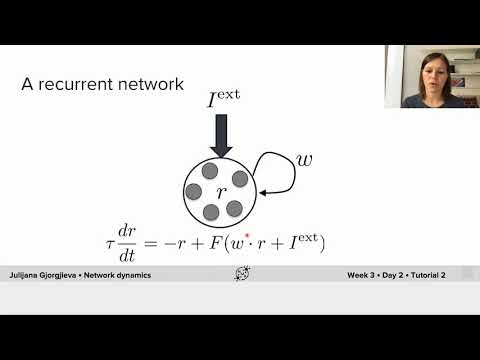

In [14]:
# @title Video 2: Fixed point
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="Ox3ELd1UFyo", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

As you varied the two parameters in the last Interactive Demo, you noticed that, while at first the system output quickly changes, with time, it reaches its maximum/minimum value and does not change anymore. The value eventually reached by the system is called the **steady state** of the system, or the **fixed point**. Essentially, in the steady states the derivative with respect to time of the activity ($r$) is zero, i.e. $\displaystyle \frac{dr}{dt}=0$. 

We can find that the steady state of the Equation. (1) by setting $\displaystyle{\frac{dr}{dt}=0}$ and solve for $r$:

$$-r_{\text{steady}} + F(w\cdot r_{\text{steady}} + I_{\text{ext}};a,\theta) = 0, \qquad (3)$$

When it exists, the solution of Equation. (3) defines a **fixed point** of the dynamical system Equation. (1). Note that if $F(x)$ is nonlinear, it is not always possible to find an analytical solution, but the solution can be found via numerical simulations, as we will do later.

From the Interactive Demo, one could also notice that the value of $\tau$ influences how quickly the activity will converge to the steady state from its initial value. 

In the specific case of $w=0$, we can also analytically compute  the solution of Equation (1) (i.e., the thick blue dashed line) and deduce the role of $\tau$ in determining the convergence to the fixed point: 

$$\displaystyle{r(t) = \big{[}F(I_{\text{ext}};a,\theta) -r(t=0)\big{]} (1-\text{e}^{-\frac{t}{\tau}})} + r(t=0)$$ \\

We can now numerically calculate the fixed point with the `scipy.optimize.root` function.

<font size=3><font color='gray'>_(Recall that at the very beginning, we `import scipy.optimize as opt` )_</font></font>.


## Exercise 2: Visualization of the fixed point

When it is not possible to find the solution for Equation (3) analytically, a graphical approach can be taken. To that end, it is useful to plot $\displaystyle{\frac{dr}{dt}=0}$ as a function of $r$. The values of $r$ for which the plotted function crosses zero on the y axis correspond to fixed points. 

Here, let us, for example, set $w=5.0$ and $I^{\text{ext}}=0.5$. From Equation (1), you can obtain

$$\frac{dr}{dt} = [-r + F(w\cdot r + I^{\text{ext}})]/\tau $$

Then, plot the $dr/dt$ as a function of $r$, and check for the presence of fixed points. 

In [15]:
pars = default_pars_single()  # get default parameters

# set your external input and wEE
pars['I_ext'] = 0.5
pars['w'] = 5.0

r = np.linspace(0, 1, 1000)  # give the values of r

# Calculate drEdt
# drdt = ...

# Uncomment this to plot the drdt across r
# plot_dr_r(r, drdt)


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


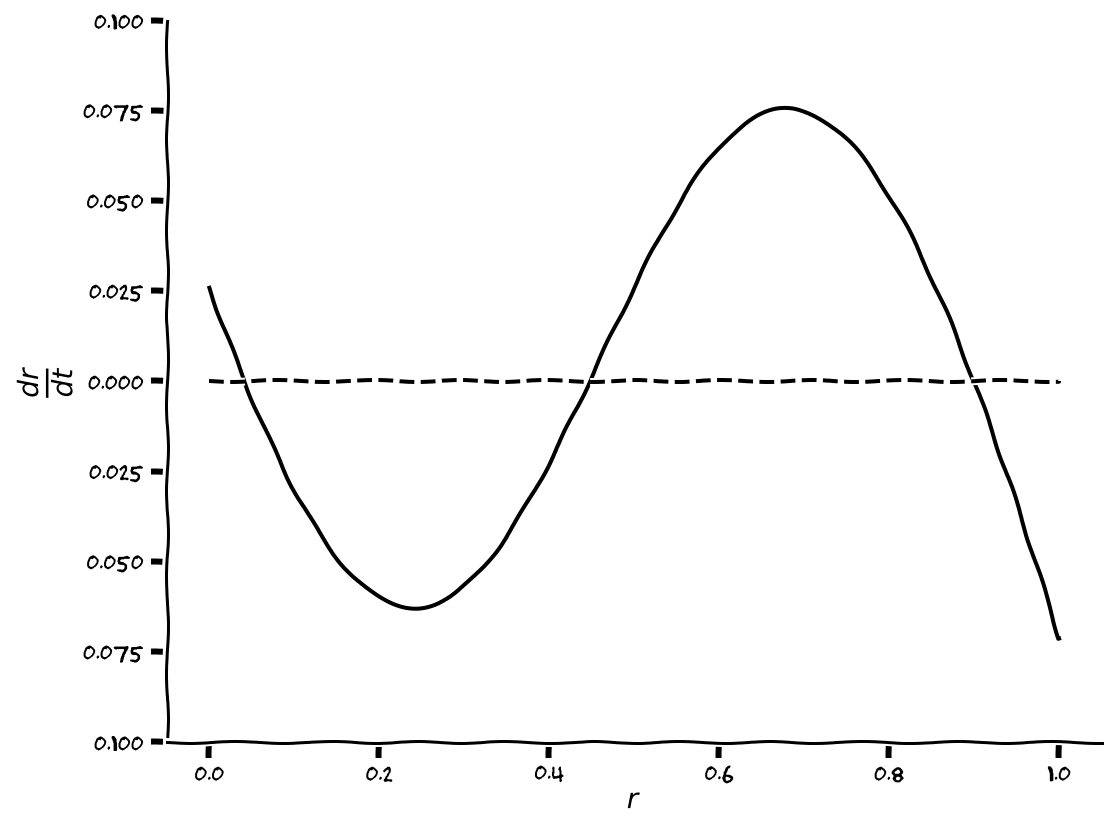

In [16]:
# to_remove solution
pars = default_pars_single()  # get default parameters

# set your external input and wEE
pars['I_ext'] = 0.5
pars['w'] = 5.0

r = np.linspace(0, 1, 1000)  # give the values of r

# Calculate drEdt
drdt = (-r + F(pars['w'] * r + pars['I_ext'],
               pars['a'], pars['theta'])) / pars['tau']

with plt.xkcd():
  plot_dr_r(r, drdt)


In [17]:
# @markdown Execute this cell to enable the functions my_fp_single and check_fp_single


def my_fp_single(pars, r_init):
  """
  Calculate the fixed point through drE/dt=0

  Args:
    pars    : Parameter dictionary
    r_init  : Initial value used for scipy.optimize function

  Returns:
    x_fp    : value of fixed point
  """

  # get the parameters
  a, theta = pars['a'], pars['theta']
  w = pars['w']
  I_ext = pars['I_ext']

  # define the right hand of E dynamics
  def my_WCr(x):
    r = x
    drdt = (-r + F(w * r + I_ext, a, theta))
    y = np.array(drdt)

    return y

  x0 = np.array(r_init)
  x_fp = opt.root(my_WCr, x0).x

  return x_fp


print(help(my_fp_single))


def check_fp_single(pars, x_fp, mytol=1e-4):
  """
   Verify |dr/dt| < mytol

  Args:
    pars    : Parameter dictionary
    fp      : value of fixed point
    mytol   : tolerance, default as 10^{-4}

  Returns :
    Whether it is a correct fixed point: True/False
  """

  a, theta = pars['a'], pars['theta']
  w = pars['w']
  I_ext = pars['I_ext']

  # calculate Equation(3)
  y = x_fp - F(w * x_fp + I_ext, a, theta)

  # Here we set tolerance as 10^{-4}
  return np.abs(y) < mytol


print(help(check_fp_single))

Help on function my_fp_single in module __main__:

my_fp_single(pars, r_init)
    Calculate the fixed point through drE/dt=0
    
    Args:
      pars    : Parameter dictionary
      r_init  : Initial value used for scipy.optimize function
    
    Returns:
      x_fp    : value of fixed point

None
Help on function check_fp_single in module __main__:

check_fp_single(pars, x_fp, mytol=0.0001)
     Verify |dr/dt| < mytol
    
    Args:
      pars    : Parameter dictionary
      fp      : value of fixed point
      mytol   : tolerance, default as 10^{-4}
    
    Returns :
      Whether it is a correct fixed point: True/False

None


## Exercise 3: Fixed point calculation

We will now find the fixed points using the previously defined function `my_fp_single(pars, r_init)` with proper initial values ($r_{\text{init}}$). From the line $\displaystyle{\frac{dr}{dt}}$ plotted above in Exercise 2, the proper initial values can be chosen as the values close to where the line crosses zero on the y axis (real fixed point).

We will use the previously defined function `check_fp_single(pars, x_fp)` to verify that the values of $r_{\rm fp}$ for which $\displaystyle{\frac{dr}{dt}} = 0$ are the true fixed points.

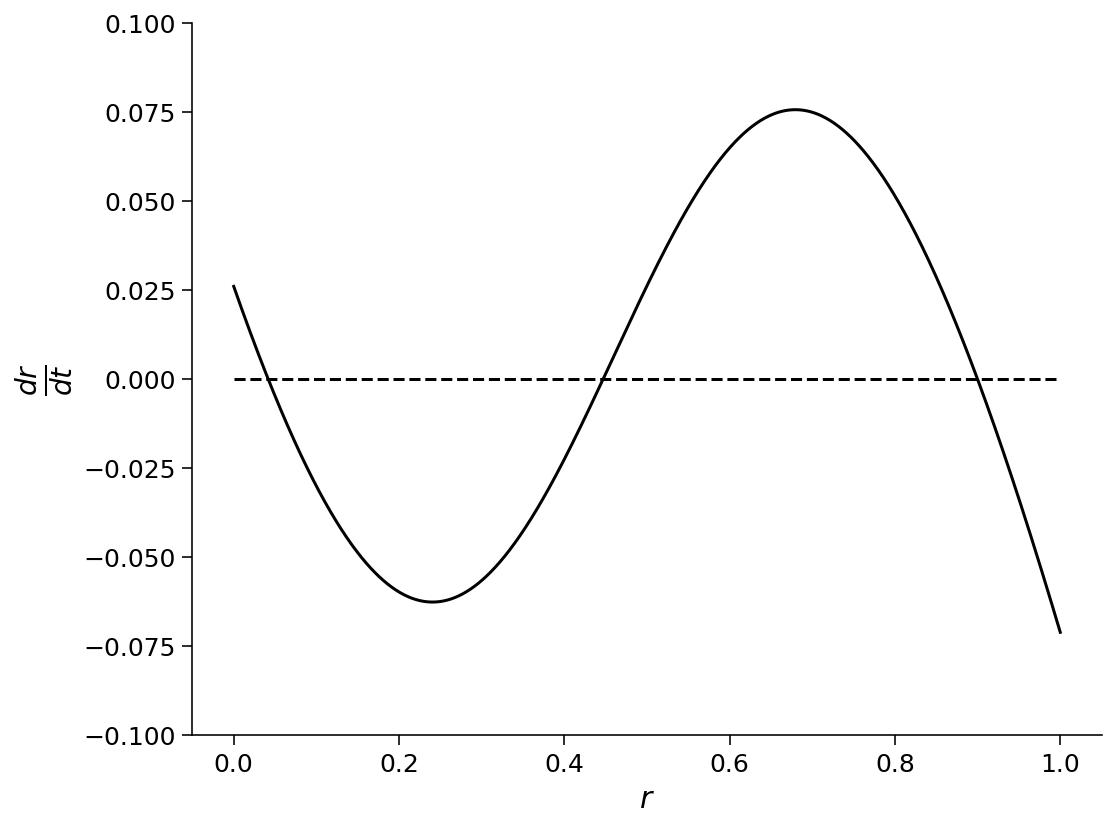

In [18]:
################################################################
# TODO for students:
# Find the values close to the intersections of drdt and y=0
# as your initial values
# Calculate the fixed point with your initial value, verify them,
# and plot the corret ones
# check if x_fp is the intersection of the lines with the given function
# check_fpE(pars, x_fp)
# vary different initial values to find the correct fixed point (Should be 3)
################################################################

plot_dr_r(r, drdt)

# Calculate the first fixed point with your initial value
# x_fp_1 = my_fp_single(pars, ...)
# if check_fp_single(pars, x_fp_1):
#   plt.plot(x_fp_1, 0, 'o', ms=8)

# Calculate the second fixed point with your initial value
# x_fp_2 = my_fp_single(pars, ...)
# if check_fp_single(pars, x_fp_2):
#   plt.plot(x_fp_2, 0, 'o', ms=8)

# Calculate the third fixed point with your initial value
# x_fp_3 = my_fp_single(pars, ...)
# if check_fp_single(pars, x_fp_3):
#   plt.plot(x_fp_3, 0, 'o', ms=8)

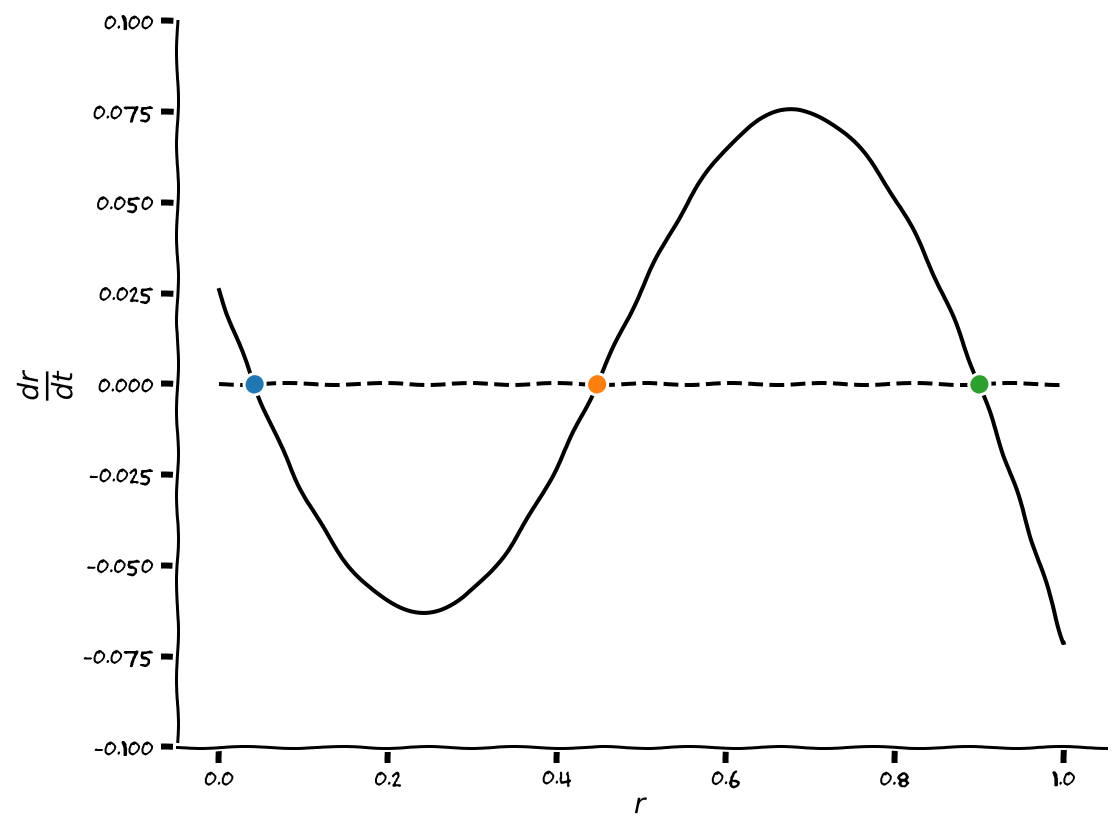

In [19]:
# to_remove solution

with plt.xkcd():
  plot_dr_r(r, drdt)

  # Calculate the first fixed point with your initial value
  x_fp_1 = my_fp_single(pars, 0.)
  if check_fp_single(pars, x_fp_1):
    plt.plot(x_fp_1, 0, 'o', ms=8)

  # Calculate the second fixed point with your initial value
  x_fp_2 = my_fp_single(pars, 0.4)
  if check_fp_single(pars, x_fp_2):
    plt.plot(x_fp_2, 0, 'o', ms=8)

  # Calculate the third fixed point with your initial value
  x_fp_3 = my_fp_single(pars, 0.9)
  if check_fp_single(pars, x_fp_3):
    plt.plot(x_fp_3, 0, 'o', ms=8)

  plt.show()

## Interactive Demo: fixed points as a function of recurrent and external inputs.

You can now explore how the previous plot changes when the recurrent coupling $w$ and the external input $I_{\text{ext}}$ take different values. How does the number of fixed points change?

In [20]:
# @title

# @markdown Make sure you execute this cell to enable the widget!


def plot_intersection_single(w, I_ext):
  # set your parameters
  pars['w'] = w
  pars['I_ext'] = I_ext

  # note that wEE!=0
  if w > 0:
    # find fixed point
    x_fp_1 = my_fp_single(pars, 0.)
    x_fp_2 = my_fp_single(pars, 0.4)
    x_fp_3 = my_fp_single(pars, 0.9)

    plt.figure()
    r = np.linspace(0, 1., 1000)
    drdt = (-r + F(w * r + I_ext, pars['a'], pars['theta'])) / pars['tau']

    plt.plot(r, drdt, 'k')
    plt.plot(r, 0. * r, 'k--')

    if check_fp_single(pars, x_fp_1):
        plt.plot(x_fp_1, 0, 'o', ms=8)
    if check_fp_single(pars, x_fp_2):
        plt.plot(x_fp_2, 0, 'o', ms=8)
    if check_fp_single(pars, x_fp_3):
        plt.plot(x_fp_3, 0, 'o', ms=8)

    plt.xlabel(r'$r$', fontsize=14.)
    plt.ylabel(r'$\frac{dr}{dt}$', fontsize=20.)

    plt.show()


_ = widgets.interact(plot_intersection_single, w=(1, 7, 0.2),
                     I_ext=(0, 3, 0.1))

interactive(children=(FloatSlider(value=4.0, description='w', max=7.0, min=1.0, step=0.2), FloatSlider(value=1…

In [21]:
# to_remove explanation

"""
Discussion: 

The fixed points of the single excitatory neuron population are determined by both 
recurrent connections w and external input I_ext. In a previous interactive demo 
we saw how the system showed two different steady-states when w = 0. But when w 
doe not equal 0, for some range of w the system shows three fixed points (the middle 
one being unstable) and the steady state depends on the initial conditions (i.e. 
r at time zero.).

More on this will be explained in the next section.
""";

---
# Summary

In this tutorial, we have investigated the dynamics of a rate-based single population of neurons.

We learned about:
- The effect of the input parameters and the time constant of the network on the dynamics of the population.
- How to find the fixed point(s) of the system.

Next, we have two Bonus, but important concepts in dynamical system analysis and simulation. If you have time left, watch the next video and proceed to solve the exercises. You will learn:

- How to determine the stability of a fixed point by linearizing the system.
- How to add realistic inputs to our model.

---
# Bonus 1: Stability of a fixed point

Video available at https://youtube.com/watch?v=KKMlWWU83Jg


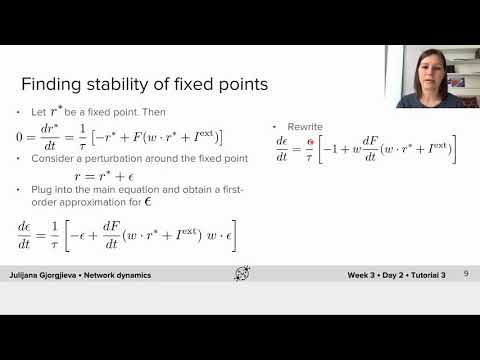

In [22]:
# @title Video 3: Stability of fixed points
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="KKMlWWU83Jg", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

#### Initial values and trajectories

Here, let us first set $w=5.0$ and $I_{\text{ext}}=0.5$, and investigate the dynamics of $r(t)$ starting with different initial values $r(0) \equiv r_{\text{init}}$. We will plot the trajectories of $r(t)$ with $r_{\text{init}} = 0.0, 0.1, 0.2,..., 0.9$.

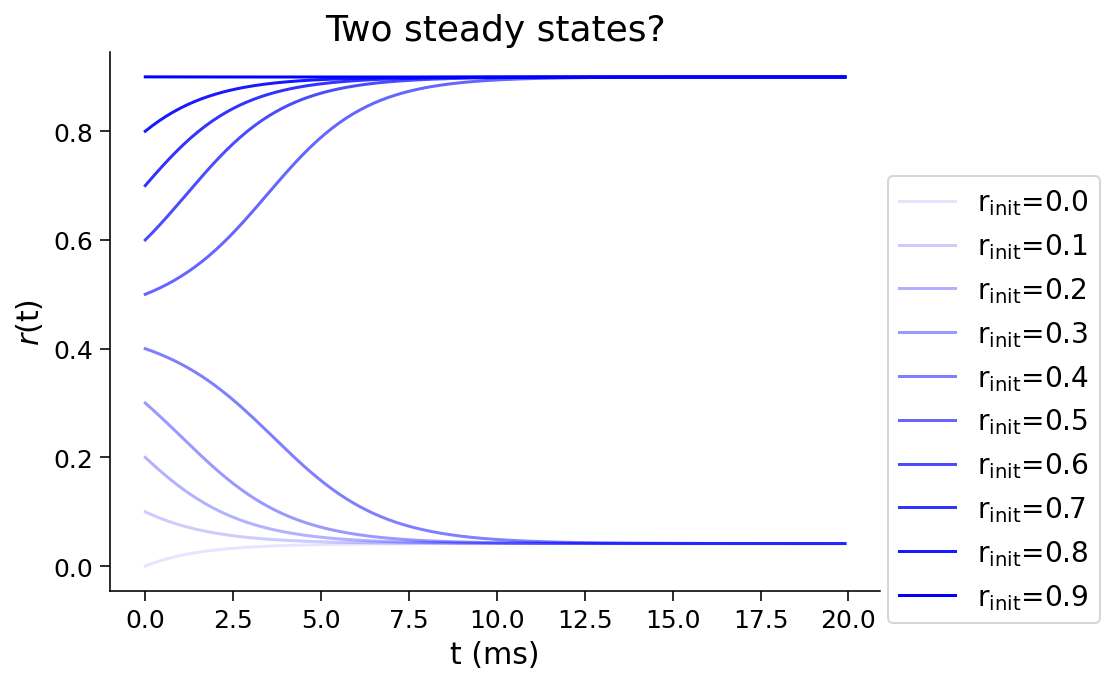

In [23]:
# @markdown Execute this cell to see the trajectories!

pars = default_pars_single()
pars['w'] = 5.0
pars['I_ext'] = 0.5

plt.figure(figsize=(8, 5))
for ie in range(10):
  pars['r_init'] = 0.1 * ie  # set the initial value
  r = simulate_single(pars)  # run the simulation

  # plot the activity with given initial
  plt.plot(pars['range_t'], r, 'b', alpha=0.1 + 0.1 * ie,
           label=r'r$_{\mathrm{init}}$=%.1f' % (0.1 * ie))

plt.xlabel('t (ms)')
plt.title('Two steady states?')
plt.ylabel(r'$r$(t)')
plt.legend(loc=[1.01, -0.06], fontsize=14)
plt.show()

## Interactive Demo: dynamics as a function of the initial value

Let's now set $r_{\rm init}$ to a value of your choice in this demo. How does the solution change? What do you observe?

In [24]:
# @title

# @markdown Make sure you execute this cell to enable the widget!

pars = default_pars_single()
pars['w'] = 5.0
pars['I_ext'] = 0.5


def plot_single_diffEinit(r_init):
  pars['r_init'] = r_init
  r = simulate_single(pars)

  plt.figure()
  plt.plot(pars['range_t'], r, 'b', zorder=1)
  plt.plot(0, r[0], 'bo', alpha=0.7, zorder=2)
  plt.xlabel('t (ms)', fontsize=16)
  plt.ylabel(r'$r(t)$', fontsize=16)
  plt.ylim(0, 1.0)
  plt.show()


_ = widgets.interact(plot_single_diffEinit, r_init=(0, 1, 0.02))

interactive(children=(FloatSlider(value=0.0, description='r_init', max=1.0, step=0.02), Output()), _dom_classe…

In [25]:
"""
Discussion: 

To better appreciate what is happening here, you should go back to the previous 
interactive demo. Set the w = 5 and I_ext = 0.5.

You will find that there are three fixed points of the system for these values of
w and I_ext. Now, choose the initial value in this demo and see in which direction 
the system output moves. When r_init is in the vicinity of the leftmost fixed points 
it moves towards the left most fixed point. When r_init is in the vicinity of the 
rightmost fixed points it moves towards the rightmost fixed point.
""";

### Stability analysis via linearization of the dynamics

Just like Equation $1$ in the case ($w=0$) discussed above, a generic linear system 
$$\frac{dx}{dt} = \lambda (x - b),$$ 
has a fixed point for $x=b$. The analytical solution of such a system can be found to be:
$$x(t) = b + \big{(} x(0) - b \big{)} \text{e}^{\lambda t}.$$ 
Now consider a small perturbation of the activity around the fixed point: $x(0) = b+ \epsilon$, where $|\epsilon| \ll 1$. Will the perturbation $\epsilon(t)$ grow with time or will it decay to the fixed point? The evolution of the perturbation with time can be written, using the analytical solution for $x(t)$, as:
 $$\epsilon (t) = x(t) - b = \epsilon \text{e}^{\lambda t}$$

- if $\lambda < 0$, $\epsilon(t)$ decays to zero, $x(t)$ will still converge to $b$ and the fixed point is "**stable**".

- if $\lambda > 0$, $\epsilon(t)$ grows with time, $x(t)$ will leave the fixed point $b$ exponentially, and the fixed point is, therefore, "**unstable**" .

### Compute the stability of Equation $1$

Similar to what we did in the linear system above, in order to determine the stability of a fixed point $r^{*}$ of the excitatory population dynamics, we perturb Equation (1) around $r^{*}$ by $\epsilon$, i.e. $r = r^{*} + \epsilon$. We can plug in Equation (1) and obtain the equation determining the time evolution of the perturbation $\epsilon(t)$:

\begin{align}
\tau \frac{d\epsilon}{dt} \approx -\epsilon + w F'(w\cdot r^{*} + I_{\text{ext}};a,\theta) \epsilon 
\end{align}

where $F'(\cdot)$ is the derivative of the transfer function $F(\cdot)$. We can rewrite the above equation as:

\begin{align}
\frac{d\epsilon}{dt} \approx \frac{\epsilon}{\tau }[-1 + w F'(w\cdot r^* + I_{\text{ext}};a,\theta)] 
\end{align}

That is, as in the linear system above, the value of

$$\lambda = [-1+ wF'(w\cdot r^* + I_{\text{ext}};a,\theta)]/\tau \qquad (4)$$

determines whether the perturbation will grow or decay to zero, i.e., $\lambda$ defines the stability of the fixed point. This value is called the **eigenvalue** of the dynamical system.

## Exercise 4: Compute $dF$ and Eigenvalue

The derivative of the sigmoid transfer function is:
\begin{align} 
\frac{dF}{dx} & = \frac{d}{dx} (1+\exp\{-a(x-\theta)\})^{-1}  \\
& = a\exp\{-a(x-\theta)\} (1+\exp\{-a(x-\theta)\})^{-2}. \qquad (5)
\end{align}

Let's now find the expression for the derivative $\displaystyle{\frac{dF}{dx}}$ in the following cell and plot it.

In [26]:
def dF(x, a, theta):
  """
  Population activation function.

  Args:
    x     : the population input
    a     : the gain of the function
    theta : the threshold of the function

  Returns:
    dFdx  : the population activation response F(x) for input x
  """

  #################################################
  # TODO for students: compute dFdx ##
  raise NotImplementedError("Student excercise: compute the deravitive of F")
  #################################################
  # Calculate the population activation
  dFdx = ...

  return dFdx


pars = default_pars_single()  # get default parameters
x = np.arange(0, 10, .1)      # set the range of input

# Uncomment below to test your function
# df = dF(x, pars['a'], pars['theta'])

# plot_dFdt(x, df)

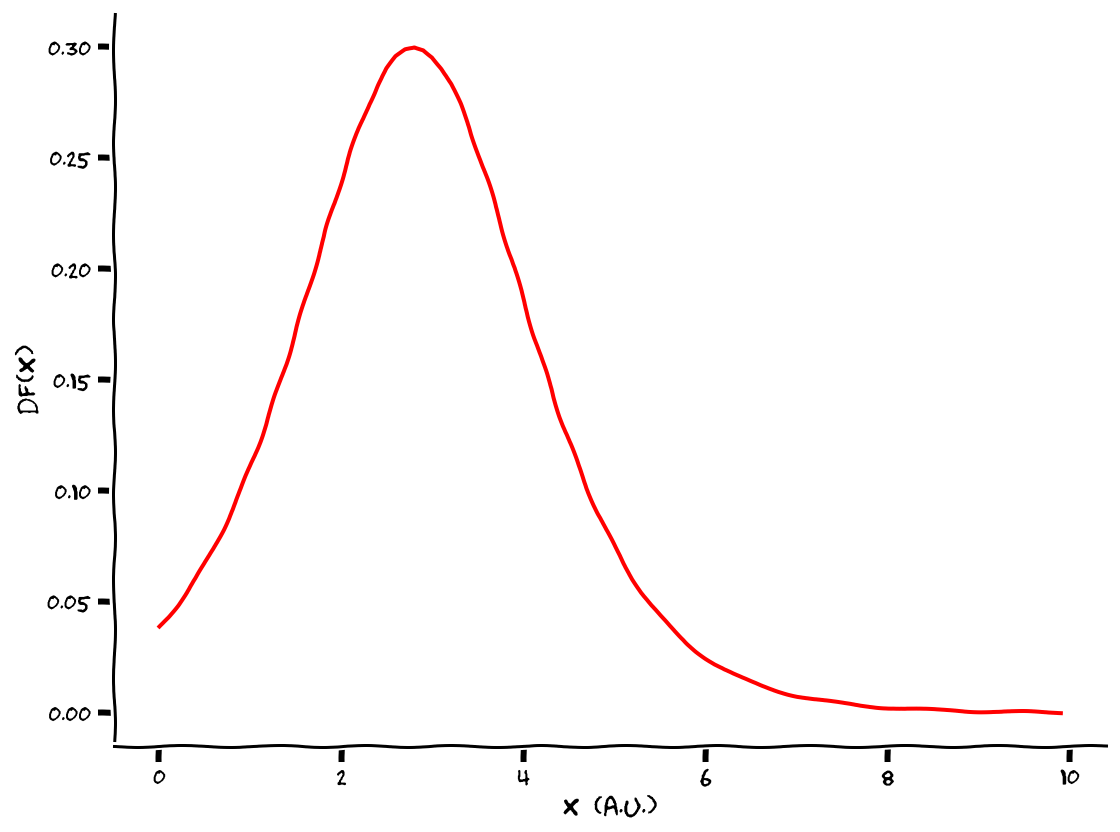

In [27]:
# to_remove solution
def dF(x, a, theta):
  """
  Population activation function.

  Args:
    x     : the population input
    a     : the gain of the function
    theta : the threshold of the function

  Returns:
    dFdx  : the population activation response F(x) for input x
  """

  # Calculate the population activation
  dFdx = a * np.exp(-a * (x - theta)) * (1 + np.exp(-a * (x - theta)))**-2

  return dFdx


pars = default_pars_single()  # get default parameters
x = np.arange(0, 10, .1)      # set the range of input

df = dF(x, pars['a'], pars['theta'])

with plt.xkcd():
  plot_dFdt(x, df)

## Exercise 5: Compute eigenvalues

As discussed above, for the case with $w=5.0$ and $I_{\text{ext}}=0.5$, the system displays **three** fixed points. However, when we simulated the dynamics and varied the initial conditions $r_{\rm init}$, we could only obtain **two** steady states. In this exercise, we will now check the stability of each of the three fixed points by calculating the corresponding eigenvalues with the function `eig_single`. Check the sign of each eigenvalue (i.e., stability of each fixed point). How many of the fixed points are stable?

Note that the expression of the eigenvalue at fixed point $r^*$
$$\lambda = [-1+ wF'(w\cdot r^* + I_{\text{ext}};a,\theta)]/\tau$$

In [28]:
def eig_single(pars, fp):
  """
  Args:
    pars : Parameter dictionary
    fp   : fixed point r_fp

  Returns:
    eig : eigevalue of the linearized system
  """

  # get the parameters
  tau, a, theta = pars['tau'], pars['a'], pars['theta']
  w, I_ext = pars['w'], pars['I_ext']
  print(tau, a, theta, w, I_ext)

  #################################################
  ## TODO for students: compute eigenvalue ##
  raise NotImplementedError("Student excercise: compute the eigenvalue")
  #################################################
  # Compute the eigenvalue
  eig = ...

  return eig


pars = default_pars_single()
pars['w'] = 5.0
pars['I_ext'] = 0.5

# Uncomment below lines after completing the eig_single function.
# Find the eigenvalues for all fixed points of Exercise 2

# x_fp_1 = my_fp_single(pars, 0.).item()
# eig_fp_1 = eig_single(pars, x_fp_1).item()
# print(f'Fixed point1 at {x_fp_1:.3f} with Eigenvalue={eig_fp_1:.3f}')

# x_fp_2 = my_fp_single(pars, 0.4).item()
# eig_fp_2 = eig_single(pars, x_fp_2).item()
# print(f'Fixed point2 at {x_fp_2:.3f} with Eigenvalue={eig_fp_2:.3f}')

# x_fp_3 = my_fp_single(pars, 0.9).item()
# eig_fp_3 = eig_single(pars, x_fp_3).item()
# print(f'Fixed point3 at {x_fp_3:.3f} with Eigenvalue={eig_fp_3:.3f}')

**SAMPLE OUTPUT**

```
Fixed point1 at 0.042 with Eigenvalue=-0.583
Fixed point2 at 0.447 with Eigenvalue=0.498
Fixed point3 at 0.900 with Eigenvalue=-0.626
```

In [29]:
# to_remove solution
def eig_single(pars, fp):
  """
  Args:
    pars : Parameter dictionary
    fp   : fixed point r_fp

  Returns:
    eig : eigevalue of the linearized system
  """

  # get the parameters
  tau, a, theta = pars['tau'], pars['a'], pars['theta']
  w, I_ext = pars['w'], pars['I_ext']
  print(tau, a, theta, w, I_ext)

  # Compute the eigenvalue
  eig = (-1. + w * dF(w * fp + I_ext, a, theta)) / tau

  return eig


pars = default_pars_single()
pars['w'] = 5.0
pars['I_ext'] = 0.5

# Find the eigenvalues for all fixed points of Exercise 2

x_fp_1 = my_fp_single(pars, 0.).item()
eig_fp_1 = eig_single(pars, x_fp_1).item()
print(f'Fixed point1 at {x_fp_1:.3f} with Eigenvalue={eig_fp_1:.3f}')

x_fp_2 = my_fp_single(pars, 0.4).item()
eig_fp_2 = eig_single(pars, x_fp_2).item()
print(f'Fixed point2 at {x_fp_2:.3f} with Eigenvalue={eig_fp_2:.3f}')

x_fp_3 = my_fp_single(pars, 0.9).item()
eig_fp_3 = eig_single(pars, x_fp_3).item()
print(f'Fixed point3 at {x_fp_3:.3f} with Eigenvalue={eig_fp_3:.3f}')

1.0 1.2 2.8 5.0 0.5
Fixed point1 at 0.042 with Eigenvalue=-0.583
1.0 1.2 2.8 5.0 0.5
Fixed point2 at 0.447 with Eigenvalue=0.498
1.0 1.2 2.8 5.0 0.5
Fixed point3 at 0.900 with Eigenvalue=-0.626


## Think! 
Throughout the tutorial, we have assumed $w> 0 $, i.e., we considered a single population of **excitatory** neurons. What do you think will be the behavior of a population of inhibitory neurons, i.e., where $w> 0$ is replaced by $w< 0$? 

In [30]:
# to_remove explanation

"""
Discussion: 

You can check this by going back the second last interactive demo and set the 
weight to w<0. You will notice that the system has only one fixed point and that 
is at zero value. For this particular dynamics, the system will eventually converge 
to zero. But try it out.
""";

---
# Bonus 2: Noisy input drives the transition between two stable states



## Ornstein-Uhlenbeck (OU) process

As discussed in several previous tutorials, the OU process is usually used to generate a noisy input into the neuron. The OU input $\eta(t)$ follows: 

$$\tau_\eta \frac{d}{dt}\eta(t) = -\eta (t) + \sigma_\eta\sqrt{2\tau_\eta}\xi(t)$$

Execute the following function `my_OU(pars, sig, myseed=False)` to generate an OU process.

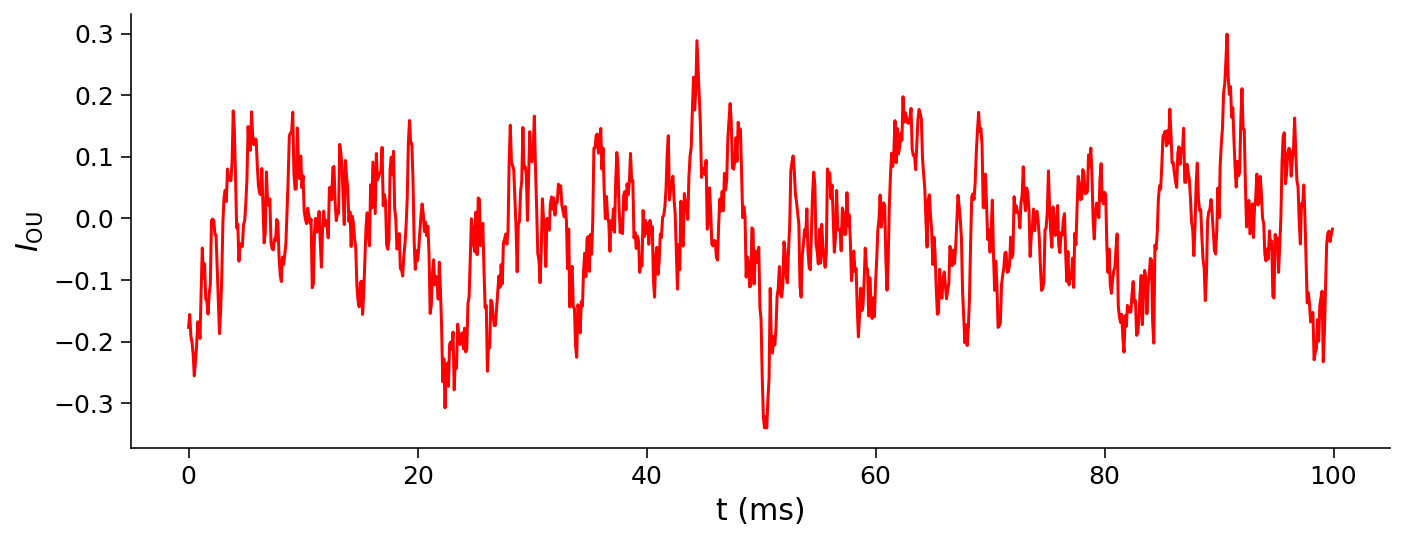

In [31]:
# @title OU process `my_OU(pars, sig, myseed=False)`

# @markdown Make sure you execute this cell to visualize the noise!


def my_OU(pars, sig, myseed=False):
  """
  A functions that generates Ornstein-Uhlenback process

  Args:
    pars       : parameter dictionary
    sig        : noise amplitute
    myseed     : random seed. int or boolean

  Returns:
    I          : Ornstein-Uhlenbeck input current
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size
  tau_ou = pars['tau_ou']  # [ms]

  # set random seed
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # Initialize
  noise = np.random.randn(Lt)
  I_ou = np.zeros(Lt)
  I_ou[0] = noise[0] * sig

  # generate OU
  for it in range(Lt - 1):
    I_ou[it + 1] = (I_ou[it]
                    + dt / tau_ou * (0. - I_ou[it])
                    + np.sqrt(2 * dt / tau_ou) * sig * noise[it + 1])

  return I_ou


pars = default_pars_single(T=100)
pars['tau_ou'] = 1.  # [ms]
sig_ou = 0.1
I_ou = my_OU(pars, sig=sig_ou, myseed=2020)
plt.figure(figsize=(10, 4))
plt.plot(pars['range_t'], I_ou, 'r')
plt.xlabel('t (ms)')
plt.ylabel(r'$I_{\mathrm{OU}}$')
plt.show()

## Example: Up-Down transition

In the presence of two or more fixed points, noisy inputs can drive a transition between the fixed points! Here, we stimulate an E population for 1,000 ms applying OU inputs.

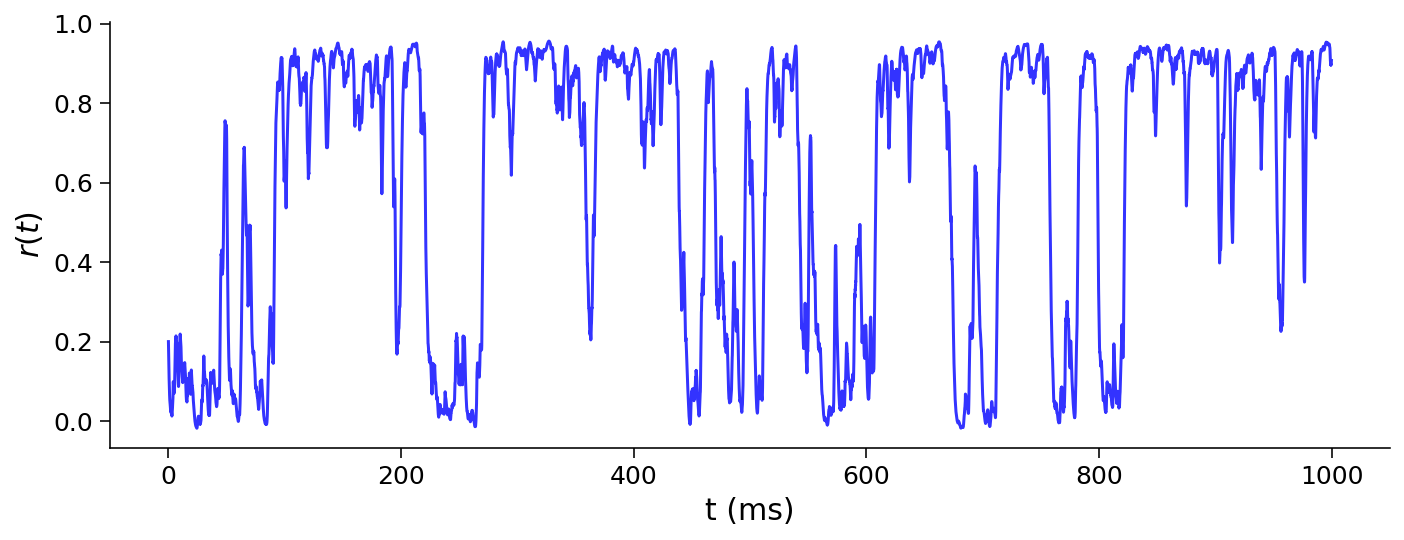

In [32]:
# @title Simulation of an E population with OU inputs

# @markdown Make sure you execute this cell to spot the Up-Down states!

pars = default_pars_single(T=1000)
pars['w'] = 5.0
sig_ou = 0.7
pars['tau_ou'] = 1.  # [ms]
pars['I_ext'] = 0.56 + my_OU(pars, sig=sig_ou, myseed=2020)

r = simulate_single(pars)

plt.figure(figsize=(10, 4))
plt.plot(pars['range_t'], r, 'b', alpha=0.8)
plt.xlabel('t (ms)')
plt.ylabel(r'$r(t)$')
plt.show()